Based on [_1](https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50) and [_2](https://www.kaggle.com/abhiksark/introduction-to-transfer-learning-cats-dogs)
# Transfer learning
It is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os, cv2, random
from tqdm import tqdm
from random import shuffle

%matplotlib inline

####################
# Global Constants #
####################
TRAIN_DIR = '../input/dogs-vs-cats-redux-kernels-edition/train'
TEST_DIR = '../input/dogs-vs-cats-redux-kernels-edition/test'
NUM_CLASSES = 2
IMG_SIZE = 224
CHANNELS = 3
EPOCHS = 10

train_images = os.listdir(TRAIN_DIR)
test_images = os.listdir(TEST_DIR)

# # For testing purposes
train_images = train_images[:10000]
test_images = test_images[:100]

In [2]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return 1
    elif word_label == 'dog' : return 0

# Return a numpy array of train and test data
def create_train_data():
    train_data = []
    for img in tqdm(train_images):
        label = label_img(img)
        img_path = os.path.join(TRAIN_DIR, img)
        img = cv2.imread(img_path, cv2.IMREAD_ANYCOLOR)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        train_data.append([np.array(img), label])
    shuffle(train_data)
    return train_data

def process_test_data():
    test_data = []
    for img in tqdm(test_images):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        test_data.append([np.array(img), img_num])
    shuffle(test_data)
    return test_data

train_data = create_train_data()
X = np.array([i[0] for i in train_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array([i[1] for i in train_data])

100%|██████████| 10000/10000 [00:36<00:00, 272.80it/s]


In [3]:
from keras.applications import ResNet50
from keras.models import Model
from keras import optimizers
from keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Path of ResNet50 pre-trained weights except its TOP layer,
RESNET_WEIGHTS_PATH = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

def build_ResNet50(input_tensor_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape= input_tensor_shape)
    
    x_model = base_model.output
    
    x_model = GlobalAveragePooling2D(name='globalaveragepooling2d')(x_model)
    
    x_model = Dense(1024, activation='relu',name='fc1_Dense')(x_model)
    x_model = Dropout(0.5, name='dropout_1')(x_model)
    
    x_model = Dense(256, activation='relu',name='fc2_Dense')(x_model)
    x_model = Dropout(0.5, name='dropout_2')(x_model)
    predictions = Dense(1, activation='sigmoid',name='output_layer')(x_model)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

model = build_ResNet50((IMG_SIZE, IMG_SIZE, CHANNELS))

# the following is option. 
# If you want to re-trian the model rather than fine-tune it just feel free to comment it.
# frozen the first 15 layers
for layer in model.layers[:175]:
    layer.trainable = False
for layer in model.layers[175:]:
    layer.trainable = True

# compile the model
model.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________

## Training

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 87s 11ms/step - loss: 0.7288 - acc: 0.6016 - val_loss: 0.3977 - val_acc: 0.9005

Epoch 00001: val_loss improved from inf to 0.39768, saving model to BestModel.hdf5
Epoch 2/10
8000/8000 [==============================] - 81s 10ms/step - loss: 0.5230 - acc: 0.7452 - val_loss: 0.2561 - val_acc: 0.9430

Epoch 00002: val_loss improved from 0.39768 to 0.25615, saving model to BestModel.hdf5
Epoch 3/10
8000/8000 [==============================] - 81s 10ms/step - loss: 0.4091 - acc: 0.8202 - val_loss: 0.1904 - val_acc: 0.9540

Epoch 00003: val_loss improved from 0.25615 to 0.19041, saving model to BestModel.hdf5
Epoch 4/10
8000/8000 [==============================] - 81s 10ms/step - loss: 0.3400 - acc: 0.8611 - val_loss: 0.1518 - val_acc: 0.9620

Epoch 00004: val_loss improved from 0.19041 to 0.15179, saving model to BestModel.hdf5
Epoch 5/10
8000/8000 [==============================] - 81s 

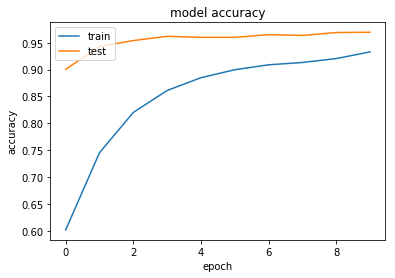

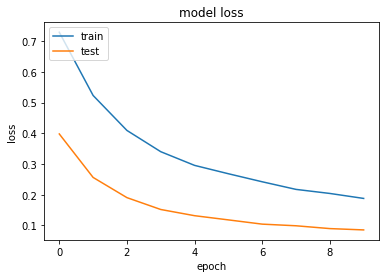

In [4]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
check_point = ModelCheckpoint('BestModel.hdf5', verbose=True, save_best_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=3, verbose=1)
history = model.fit(X, y,
                    validation_split=0.2,
                    callbacks = [check_point, lr_reduce],
                    epochs=EPOCHS,
                    batch_size=80,
                    verbose=1)

# Plotting loss and accuracy for the model
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Testing

100%|██████████| 100/100 [00:00<00:00, 193.94it/s]


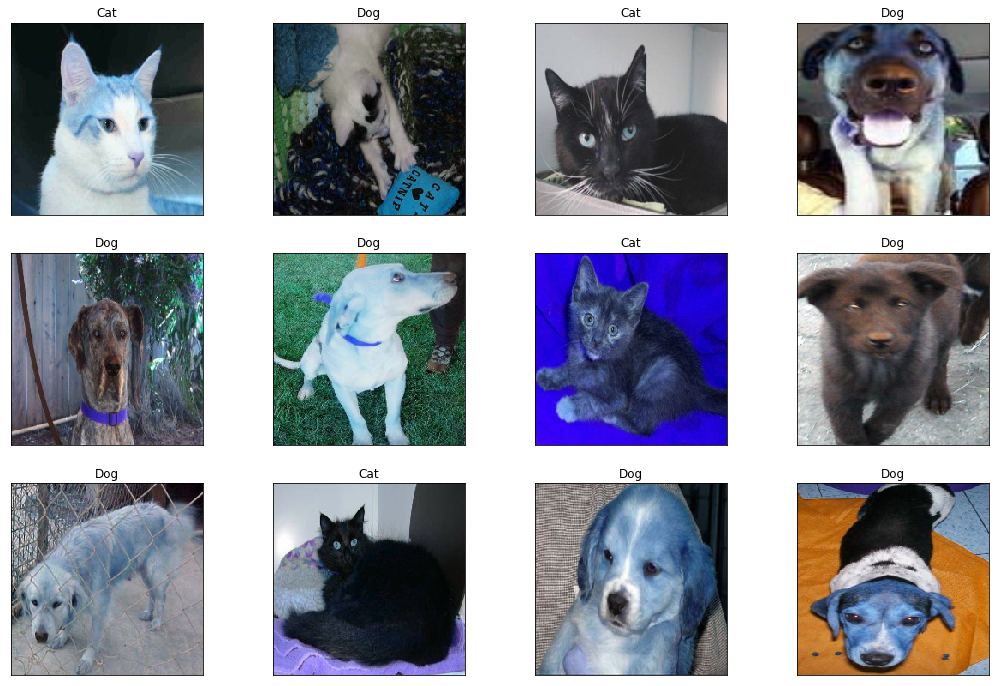

In [5]:
# Free some space
import gc
del X, y, train_data
gc.collect()

# Load Best model
from keras.models import load_model
model = load_model('BestModel.hdf5')

# Testing Model on Test Data
test_data = process_test_data()
fig =plt.figure(figsize=(18, 12))
for num, data in enumerate(test_data[:12]):
    # Cat: [1]
    # Dog: [0]
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3, 4, num+1)
    data = img_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    model_out = model.predict([data])[0]
    
    if model_out >= 0.5 : str_label ='Cat'
    else: str_label = 'Dog'
    y.imshow(img_data)
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False);
    y.axes.get_yaxis().set_visible(False);
plt.show()

## Generate .csv for submission

In [6]:
prob = []
img_list = []
for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
        model_out = model.predict([data])[0]
        img_list.append(img_num)
        prob.append(model_out[0])
    
submission = pd.DataFrame({'id':img_list , 'label':prob})
print(submission.head())
submission.to_csv("submit.csv", index=False)

100%|██████████| 100/100 [00:02<00:00, 36.05it/s]


      id     label
0  10341  0.999125
1   7829  0.428129
2  11721  0.999404
3  11157  0.000949
4  11953  0.000564
